## 1 Импорт библиотек

In [1]:
import requests
import fake_useragent
from bs4 import BeautifulSoup
import time
from tqdm import tqdm
import re
import pandas as pd
import unicodedata
import plotly.express as px
from datetime import date
import numpy as np
import plotly.graph_objects as go

## 2 Сбор данных

### 2.1 Определение вакансий для анализа

In [2]:
vac = ['Data analyst', 'System analyst', 'BI analyst', 'Business analyst', 'Product analyst',\
       'Data engineer', 'Machine learning engineer', 'Data scientist', 'Quantitative researcher']
exp = ['noExperience', 'between1And3', 'between3And6', 'moreThan6']

##### Так как у hh существует ограничение на количество получаемый вакансий(2000), то обходим его с помощью указания опыта работы

### 2.2 Создание функции для сбора ссылок всех вакансий

Одна из задач - получить ключевые навыки каждой вакансии. Они отображаются только на странице вакансии, из обычного поиска их не извлечь. Сначала нужно извлечь ссылку на каждую вакансию

Вариант с hh.api работает дольше(для получения ссылок на вакансии), поэтому используем requests

**Сбор вакансий производим по всей России(area=113)**

In [3]:
def get_links(vacancy:list):
    for vac in vacancy:
        for ex in exp:
            ua = fake_useragent.UserAgent()
            res = requests.get(
                url=f'https://hh.ru/search/vacancy?area=113&experience={ex}&text={vac}&items_on_page=20',
                headers={"user-agent":ua.random}
            )
            if res.status_code != 200:
                return
            soup = BeautifulSoup(res.content, "lxml")
            try:
                page_count = int(soup.find("div",attrs={"class":"pager"}).find_all("span",\
                recursive=False)[-1].find("a").find("span").text)
            except:
                page_count = 1
            for page in range(page_count):
                try:
                    res = requests.get(
                        url=f"https://hh.ru/search/vacancy?area=113&page={page}&experience={ex}&text={vac}&items_on_page=20",
                        headers={"user-agent":ua.random}
                    )
                    if res.status_code == 200:
                        soup = BeautifulSoup(res.content, "lxml")
                        for a in soup.find_all("a", attrs={"class": "serp-item__title"}):
                            vac_number = re.findall(r"\d+", a.attrs["href"])[0]
                            yield [f'https://hh.ru/vacancy/{vac_number}', vac]
                except Exception as e:
                    print(f"{e}")
                time.sleep(0.1)

### 2.3 Создание функции для сбора информации о каждой вакансии

Получив список из ссылок с вакансиями, проходим по каждой и получаем информацию:  
        **id** — уникальный id, по которому можно однозначно определить вакансию   
        **name** — название вакансии  
        **company** — работодатель(компания)  
        **salary** — зарплата  
        **experience** — требуемый опыт работы  
        **schedule** — тип занятости и график работы  
        **published_at** — дата публикации  
        **tags** — ключевые навыки  
        **role** — тег, который показывает по какому запросу получили эту вакансию

In [4]:
def get_vacancy(link):
    ua = fake_useragent.UserAgent()
    data = requests.get(
        url = link[0],
        headers={"user-agent":ua.random}
    )
    if data.status_code != 200:
        return
    soup = BeautifulSoup(data.content, "lxml")
    try:
        id = int(''.join(re.findall(r"\d+", link[0])))
    except:
        id = ""
    try:
        name = soup.find(attrs={"data-qa":"vacancy-title"}).text
    except:
        name = ''
    try:
        salary = soup.find(attrs={"data-qa":"vacancy-salary"}).\
        text.replace("\u2009","").replace("\xa0"," ")
    except:
        salary = ""
    try:
        tags = [tag.text for tag in soup.find(attrs={"class":"bloko-tag-list"}).\
                find_all("span",attrs={"class":"bloko-tag__section_text"})]
    except:
        tags = []
    try:
        experience = soup.find(attrs={"data-qa":"vacancy-experience"}).text
    except:
        experience = ""
    try:
        company = soup.find(attrs={"data-qa":"bloko-header-2"}).text.replace("\u2009","").replace("\xa0"," ")
    except:
        company = ""
    try:
        schedule = soup.find(attrs={"data-qa":"vacancy-view-employment-mode"}).text
    except:
        schedule = ""  
    try:
        published_at = soup.find(attrs={"class":"vacancy-creation-time-redesigned"}).\
        text.replace("\u2009","").replace("\xa0"," ").split(' ')[2:5]
    except:
        published_at = ""  
    vacancy = {
        'id': id,
        "name": name,
        "company": company,
        "salary": salary,
        "experience": experience,
        'schedule': schedule,
        'published_at': published_at,
        "tags": tags,
        "role": link[1],
    }
    return vacancy

### 2.4 Сбор данных о вакансиях

In [5]:
%%time
link_list = []
for link in get_links(vac):
    link_list.append(link)

CPU times: total: 1min 32s
Wall time: 15min 6s


Получили список с ссылками на вакансии и тегами, по которым эти вакансии нашлись

In [ ]:
data = []
for link in link_list:
    data.append(get_vacancy(link))
    time.sleep(0.1)

Получили словарь с данными о всех вакансиях

### 2.5 Сбор данных о курсах валют для конвертации

Получаем курсы валют с сайта ЦБ РФ

In [8]:
ua = fake_useragent.UserAgent()
data2 = requests.get(
    url = 'https://www.cbr.ru/currency_base/daily/',
    headers={"user-agent":ua.random}
)
if data2.status_code != 200:
    pass
soup = BeautifulSoup(data2.content, "lxml")

In [9]:
table_body=soup.find('tbody')
rows = table_body.find_all('tr')
exchange = []
for row in rows:
    cols = row.find_all('td')
    cols = [x.text.strip() for x in cols]
    exchange.append(cols)

In [10]:
exchange_rates = pd.DataFrame(exchange, columns = ['number_code', 'letter_code', 'quant', 'currency', 'rate'])\
.dropna().reset_index(drop=True)
exchange_rates['rate'] = exchange_rates['rate'].apply(lambda x: x.replace(',', '.'))
exchange_rates[['quant', 'rate']] = exchange_rates[['quant', 'rate']].astype(float)

In [11]:
exchange_rates.head(3)

,number_code,letter_code,quant,currency,rate
0,036,AUD,1.0,Австралийский доллар,51.8994
1,944,AZN,1.0,Азербайджанский манат,45.4843
2,051,AMD,100.0,Армянских драмов,19.9041


## 3 Предобработка данных

### 3.1 Обработка возможных ошибок

При парсинге некоторые данные могли некорректно сохраниться или не сохраниться

In [12]:
temp = [value for value in data.copy() if value != None]
len(temp)

13856

In [13]:
len(data)

13857

In [14]:
def ex(currency):
    if currency in exchange_rates.letter_code.values:
        return float((exchange_rates[exchange_rates.letter_code==currency].\
    rate/exchange_rates[exchange_rates.letter_code==currency].quant).values)

In [15]:
df = pd.DataFrame(temp)
df.head(1)

,id,name,company,salary,experience,schedule,published_at,tags,role
0,78006685,Data Analyst (Junior),DNS Технологии,от 70 000 руб. на руки,не требуется,"Полная занятость, полный день","[31, марта, 2023]","[Pandas, PostgreSQL, Python, SQL, ClickHouse, ...",Data analyst


Удаление вакансий, которые не удалось получить(вакансии могли быть скрыты или помещены в архив)

In [16]:
df = df[~df['name'].isna()]
df = df[df['name'] != '']

Удаление дубликатов вакансий(по разным запросам можно найти одну и ту же вакансию)

In [17]:
df = df.drop_duplicates(subset=['id'], keep='last').reset_index(drop=True)

Больше 3000 тысяч вакансий оказались дубликатами

In [18]:
df

,id,name,company,salary,experience,schedule,published_at,tags,role
0,78006685,Data Analyst (Junior),DNS Технологии,от 70 000 руб. на руки,не требуется,"Полная занятость, полный день","[31, марта, 2023]","[Pandas, PostgreSQL, Python, SQL, ClickHouse, ...",Data analyst
1,78787579,Аналитик-исследователь,Mediascope,з/п не указана,не требуется,"Полная занятость, полный день","[31, марта, 2023]","[R, SQL, Английский язык, Git, Аналитические и...",Data analyst
2,76240797,Аналитик данных,ООО РСХБ-Интех,з/п не указана,не требуется,"Полная занятость, полный день","[26, марта, 2023]",[],Data analyst
3,78266507,Junior Data Analyst,"РЕСО-Гарантия, САО",з/п не указана,не требуется,"Полная занятость, полный день","[20, марта, 2023]",[],Data analyst
4,78155321,Junior Data Analyst,ООО АТОН,з/п не указана,не требуется,"Полная занятость, полный день","[16, марта, 2023]",[Python],Data analyst
...,...,...,...,...,...,...,...,...,...
10655,78290216,Market Insights Analyst,Essity,з/п не указана,3–6 лет,"Полная занятость, полный день","[20, марта, 2023]",[Английский — B2 — Средне-продвинутый],Quantitative researcher
10656,77875369,HR BP / HR Business Partner (в Грузию),Cointelegraph Consulting,з/п не указана,3–6 лет,"Полная занятость, полный день","[10, марта, 2023]","[HR Business Strategy, Performance Management,...",Quantitative researcher
10657,75629410,BI & Consumer Insights Manager,Perfetti Van Melle,з/п не указана,3–6 лет,"Полная занятость, полный день","[6, марта, 2023]","[Project management, Английский язык, Английск...",Quantitative researcher
10658,77772102,B2B Marketing Manager,"Emerging Travel Group (Ostrovok.ru, B2B.Ostrov...",з/п не указана,3–6 лет,"Полная занятость, удаленная работа","[7, марта, 2023]",[Английский — C1 — Продвинутый],Quantitative researcher


### 3.2 Обработка зарплаты

Есть несколько видов указания зарплаты:  
    — указана нижняя граница зарплаты  
    — указана верняя граница зарплаты  
    — указана нижняя и верхняя граница зарплаты  
    — не указана зарплата  
Зарплата может быть указана в валюте отличной от 'руб.' и два варианта выплаты 'gross' и 'net'  
Всю зарплату будем переводить к 'gross'  

Определение типа зп

In [19]:
df['salary_type'] = df.salary.apply(lambda x: 'net' if 'на руки' in str(x) 
                                    else('gross' if 'до вычета налогов' in str(x) else np.NaN))
df['salary'] = df['salary'].apply(lambda x:x.replace(' на руки', '').replace(' до вычета налогов', ''))

In [20]:
df[df.experience=='']

,id,name,company,salary,experience,schedule,published_at,tags,role,salary_type


In [21]:
df.experience.value_counts()

3–6 лет         4983
1–3 года        4826
более 6 лет      431
не требуется     420
Name: experience, dtype: int64

Разделение зп на колонки 'нижняя граница зп', 'верхняя граница зп' и 'валюта зп'

In [22]:
df['salary_from'] = df['salary'].apply(lambda x: float(''.join(re.findall(r"\d+", x[x.find('от')+3:x.find('до')-1])))
                                       if ('от' in x) else np.NaN)
df['salary_to'] = df['salary'].apply(lambda x: float(''.join(re.findall(r"\d+", x[x.find('до')+3:])))
                                       if ('до' in x) else np.NaN)
df['currency'] = df['salary'].apply(lambda x: x[re.match('.+([0-9])[^0-9]*$', x).start(1)+2:].split(' ')[0] 
                                   if x!='з/п не указана' else np.NaN)
df['salary_from'] = df.apply(lambda row: row['salary_from']/0.87 if row['salary_type'] == 'net' 
                             else row['salary_from'], axis=1).apply(np.floor)
df['salary_to'] = df.apply(lambda row: row['salary_to']/0.87 if row['salary_type'] == 'net' 
                           else row['salary_to'], axis=1).apply(np.floor)

Если зп указана в валюте, отличной от руб., то конвертируем ее по текущему курсу ЦБ РФ

In [23]:
df['salary_from_rub'] = df.apply(
    lambda row: row['salary_from'] * ex(row['currency'])
        if row['currency'] !='руб.' and not pd.isnull(row['currency'])
            else row['salary_from'], axis=1).apply(np.floor)
df['salary_to_rub'] = df.apply(
    lambda row: row['salary_to'] * ex(row['currency'])
        if row['currency'] !='руб.' and not pd.isnull(row['currency'])
            else row['salary_to'], axis=1).apply(np.floor)

In [24]:
df_salary = df[~df.salary_type.isnull()].copy()

Считаем среднее для каждой вилки зп

In [25]:
df_salary['mean'] = df_salary.iloc[:,[-1, -2]].mean(axis=1)

Проверяем зарплаты на корректность  
Если зарплата меньше 1000, значит умножаем на тысячу 

In [26]:
df_salary[df_salary['mean'] < 1000]['mean'] = df_salary[df_salary['mean'] <= 1000]['mean'].apply(lambda x: 1000*x)

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_5592\126005646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_salary[df_salary['mean'] < 1000]['mean'] = df_salary[df_salary['mean'] <= 1000]['mean'].apply(lambda x: 1000*x)


In [27]:
df[~pd.isnull(df.currency)].head(3) 

,id,name,company,salary,experience,schedule,published_at,tags,role,salary_type,salary_from,salary_to,currency,salary_from_rub,salary_to_rub
0,78006685,Data Analyst (Junior),DNS Технологии,от 70 000 руб.,не требуется,"Полная занятость, полный день","[31, марта, 2023]","[Pandas, PostgreSQL, Python, SQL, ClickHouse, ...",Data analyst,net,80459.0,NaN,руб.,80459.0,NaN
7,77693249,Data analytics (Стажер),ПАО КБ Уральский банк реконструкции и развития...,до 25 400 руб.,не требуется,"Стажировка, полный день","[6, марта, 2023]","[Python, SQL, Математический анализ, Работа с ...",Data analyst,gross,NaN,25400.0,руб.,NaN,25400.0
11,77766028,Специалист по разработке и обучению голосовых ...,ROBOTMIA,до 50 000 руб.,не требуется,"Полная занятость, гибкий график","[31, марта, 2023]","[Бизнес-анализ, Аналитическое мышление, Усидчи...",Data analyst,net,NaN,57471.0,руб.,NaN,57471.0


## 4 Визуализация

### 4.1 Количество вакансий, которые были опубликованы за март 2023

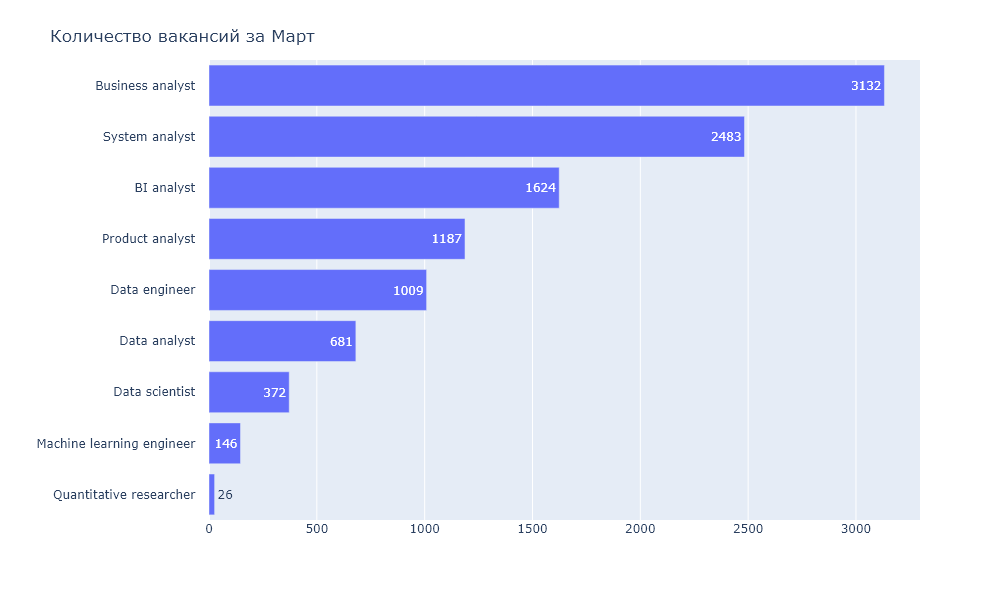

In [28]:
fig = px.bar(x=df.groupby('role')['id'].count().sort_values(), 
             y = [label+' '* 3 for label in df.groupby('role')['id'].count().sort_values().index], 
             text_auto=True, labels = {'x': '', 'y': ''}, width=1000, height=600)
fig.update_layout(
    title={
        'text': f'Количество вакансий за Март', 
        'yanchor': 'top'})
fig.show("png")

### 4.2 Распределение вакансий по направлениям в сфере аналитики

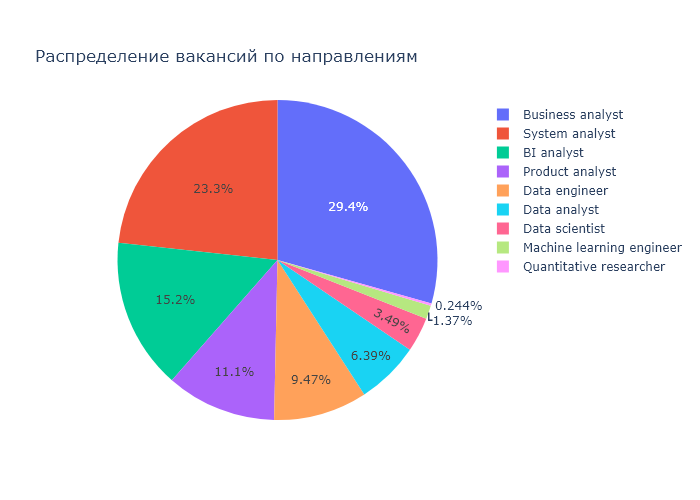

In [29]:
fig = go.Figure()
fig.add_trace(go.Pie(values=df.groupby('role')['id'].count().sort_values(),\
                     labels=df.groupby('role')['id'].count().sort_values().index))
fig.update_layout(
    title={
        'text': f'Распределение вакансий по направлениям', 
        'yanchor': 'top'})
fig.show("png")

### 4.3 Распределение вакансий по опыту

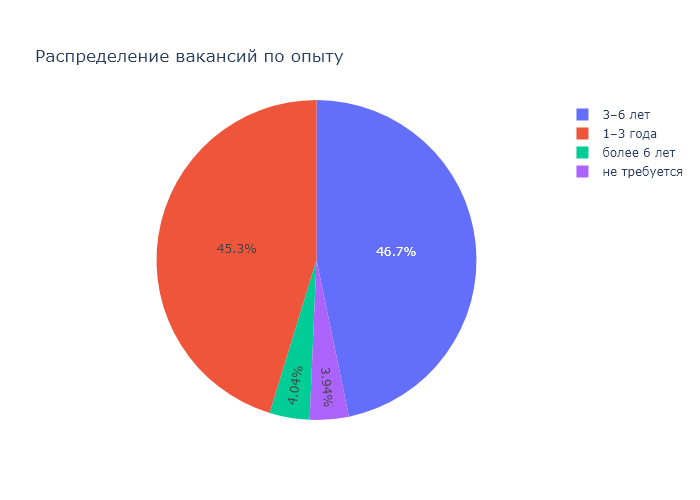

In [30]:
fig = go.Figure()
fig.add_trace(go.Pie(values=df.groupby('experience')['id'].count().sort_values(),\
                     labels=df.groupby('experience')['id'].count().sort_values().index))
fig.update_layout(
    title={
        'text': f'Распределение вакансий по опыту', 
        'yanchor': 'top'})
fig.show("png")

### 4.4 Распределение зарплат по опыту во всех направлениях

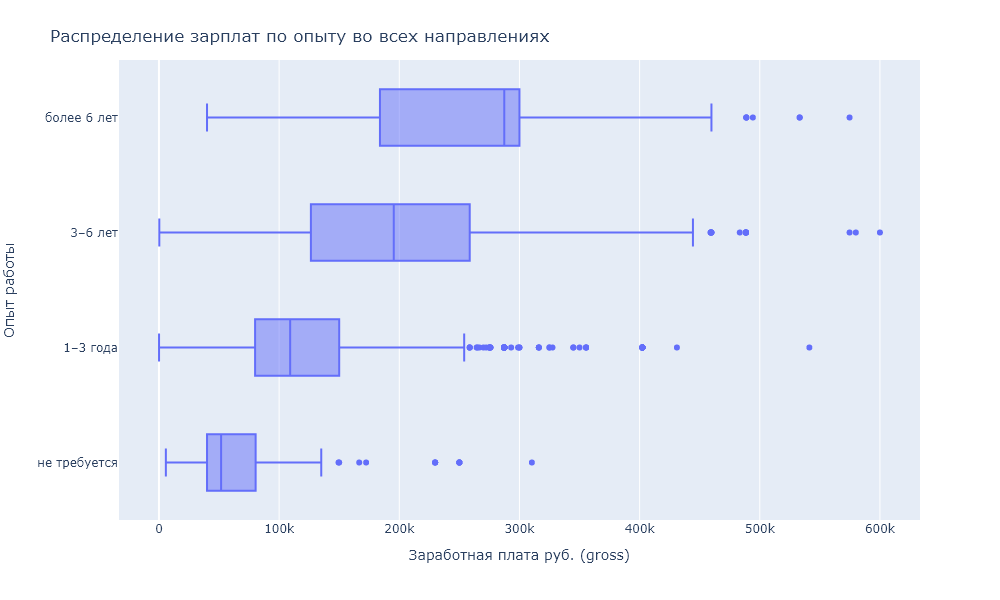

In [31]:
fig = px.box(df_salary, x = 'mean', y = 'experience', 
             labels = {'mean': 'Заработная плата руб. (gross)', 'experience': 'Опыт работы'}, width=1000, height=600)
fig.update_layout(
    title={
        'text': f'Распределение зарплат по опыту во всех направлениях', 
        'yanchor': 'top'})
fig.show("png")

### 4.5 Распределение зарплат по опыту для каждого направления

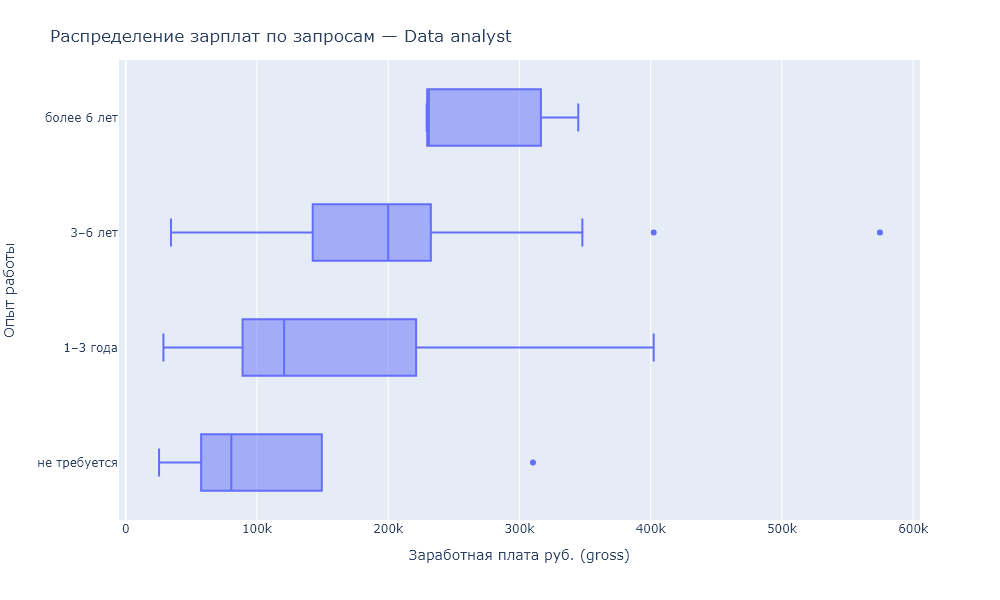

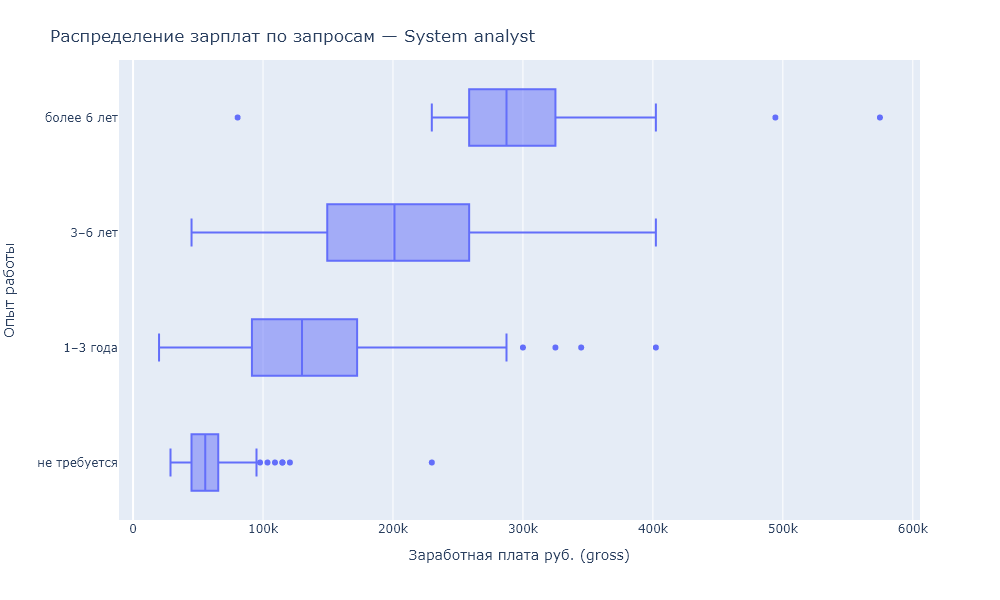

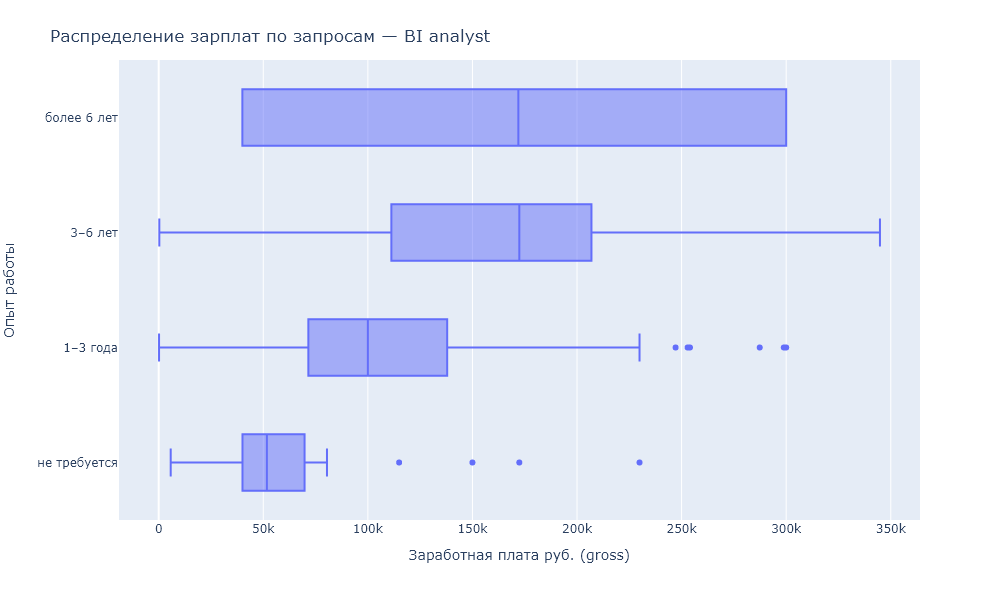

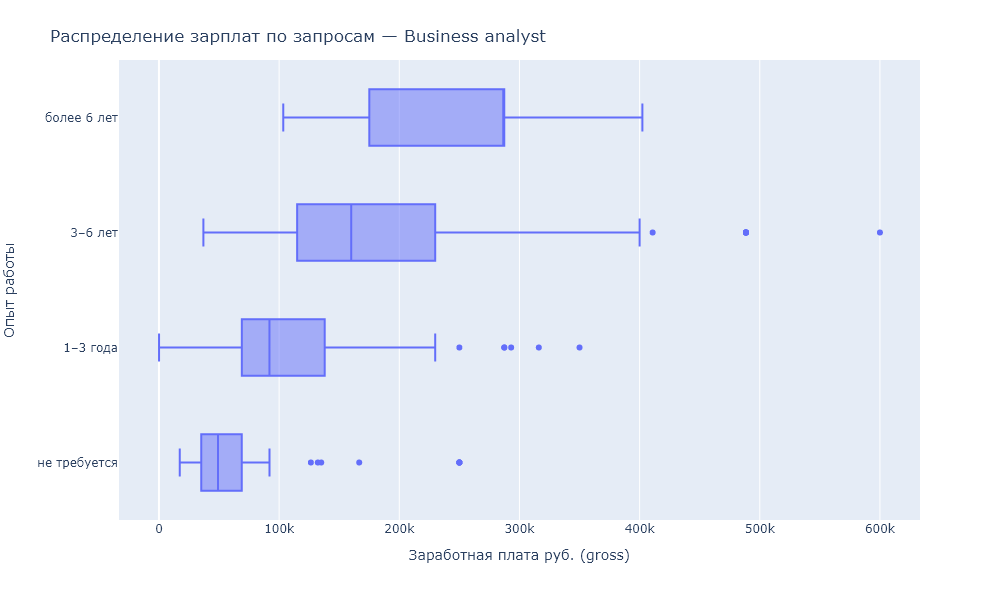

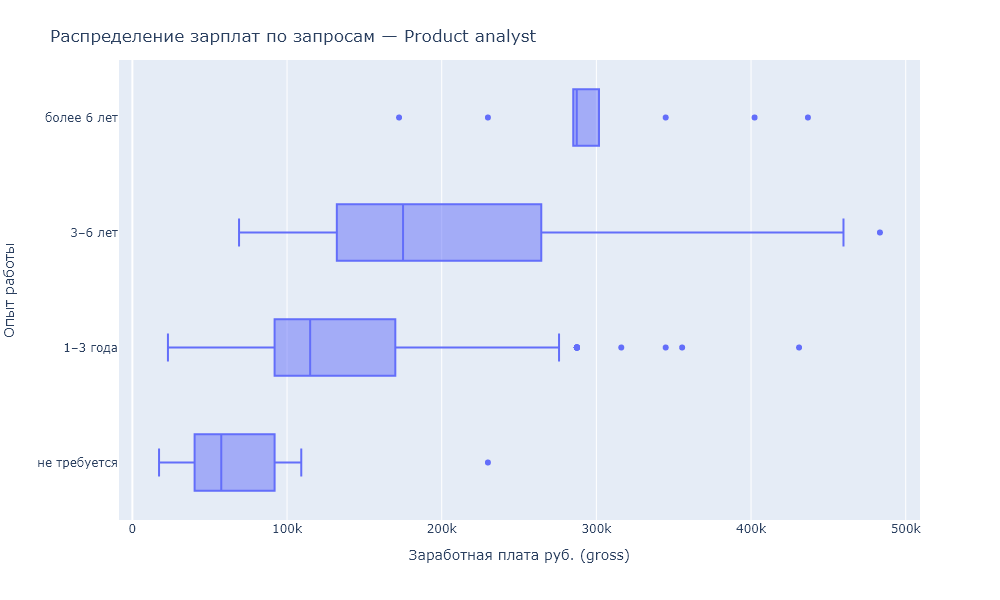

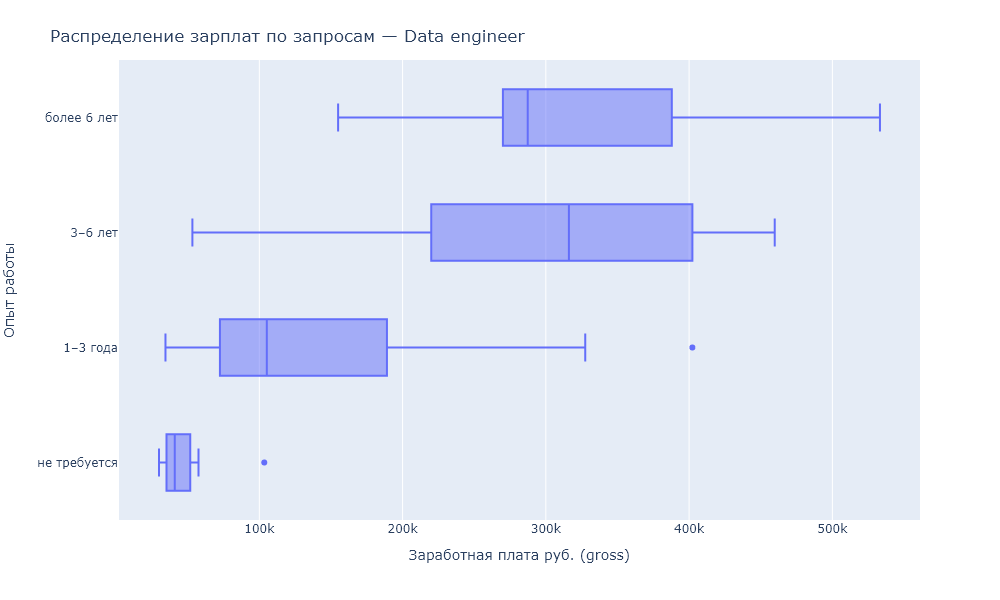

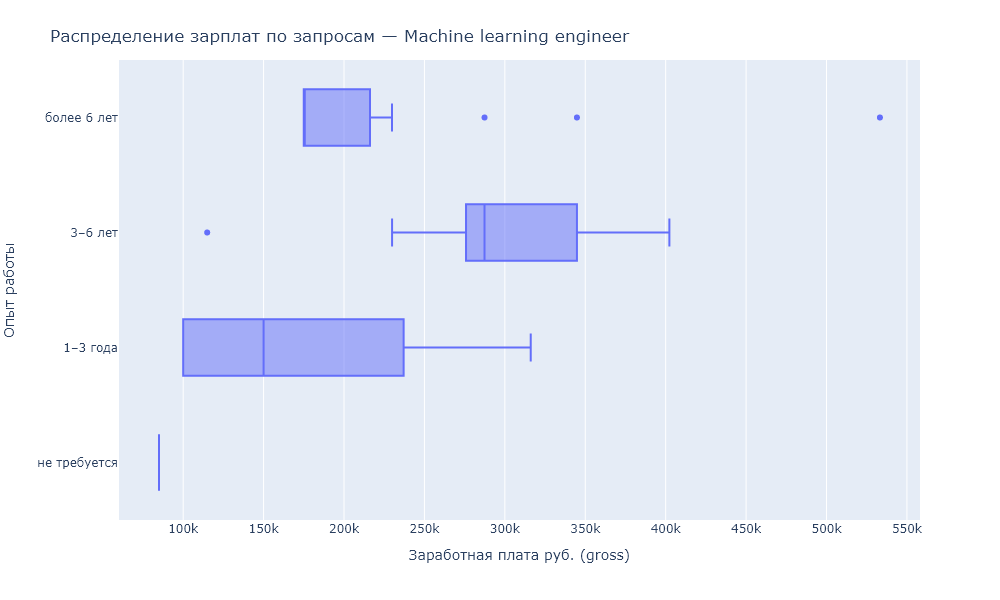

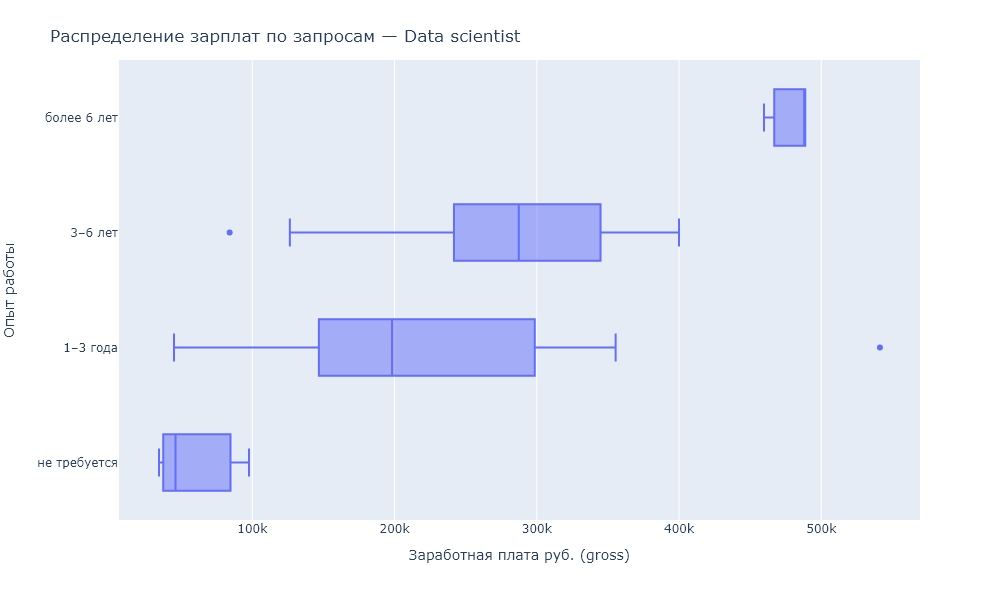

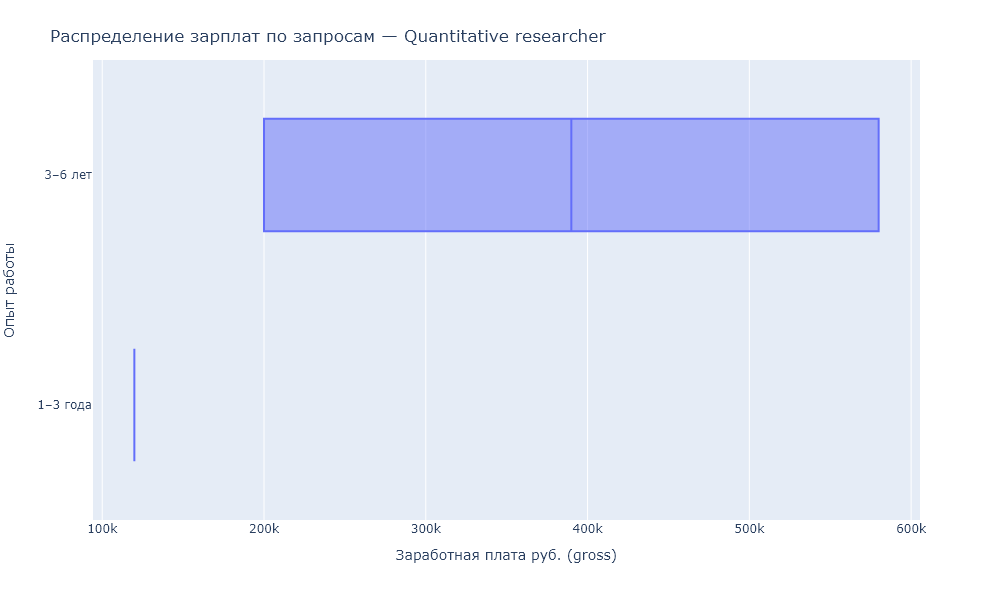

In [32]:
for va in vac:
    fig = px.box(df_salary[df_salary.role == va], x = 'mean', y = 'experience', 
                 labels = {'mean': 'Заработная плата руб. (gross)', 'experience': 'Опыт работы'}, width=1000, height=600
    )
    fig.update_layout(
        title={
            'text': f'Распределение зарплат по запросам — {va}', 
            'yanchor': 'top'})
    fig.show("png")

### 4.6 Самые востребованные навыки во всех направлениях(топ 20)

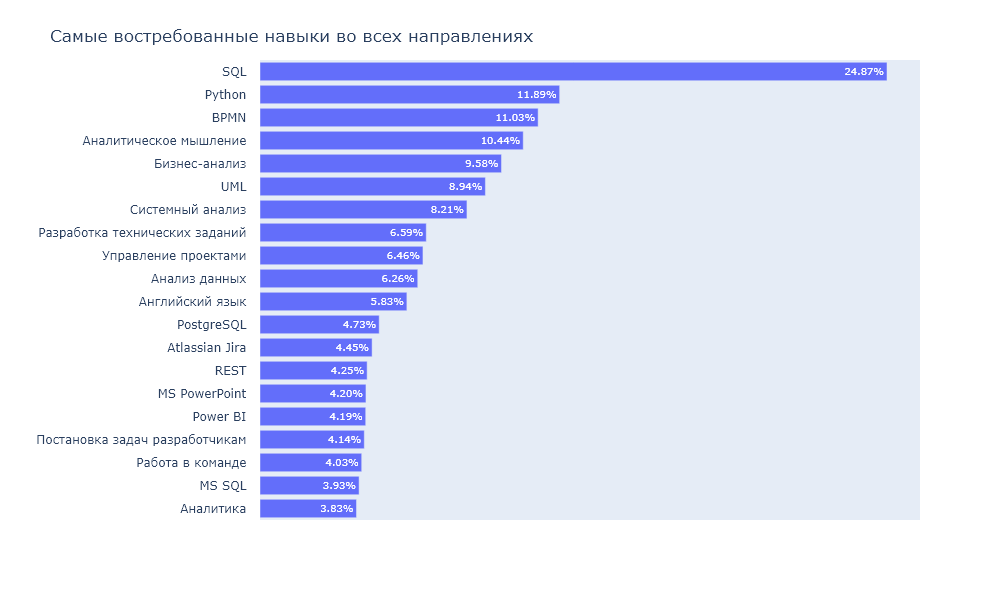

In [33]:
skills = (pd.Series([x for b in df['tags'] for x in b]).value_counts()/len(df))[:20]
fig = px.bar(x = skills.sort_values().values, y = [label+' '* 3 for label in skills.sort_values().index], 
             text_auto='.2%', labels = {'x': '', 'y': ''}, width=1000, height=600)
fig.update_layout(
    title={
        'text': f'Самые востребованные навыки во всех направлениях', 
        'yanchor': 'top'})
fig.update_xaxes(visible=False)
fig.show("png")

### 4.7 Самые востребованные навыки по каждому направлению

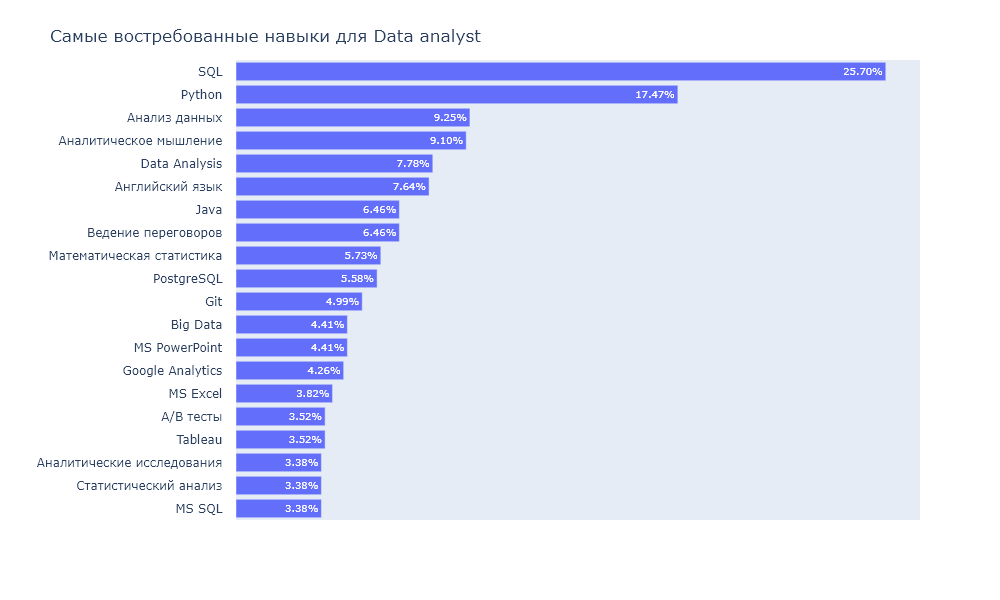

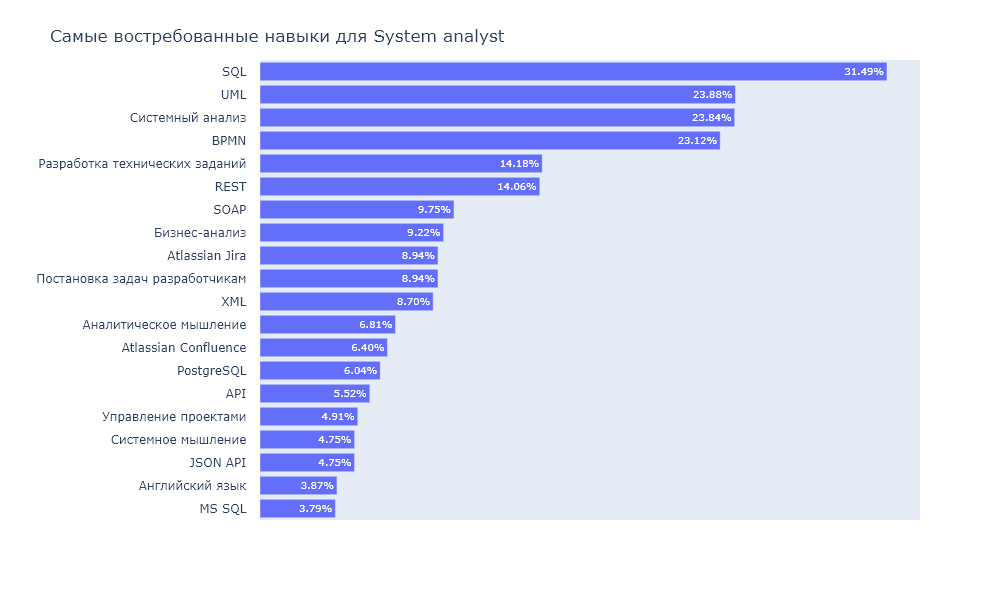

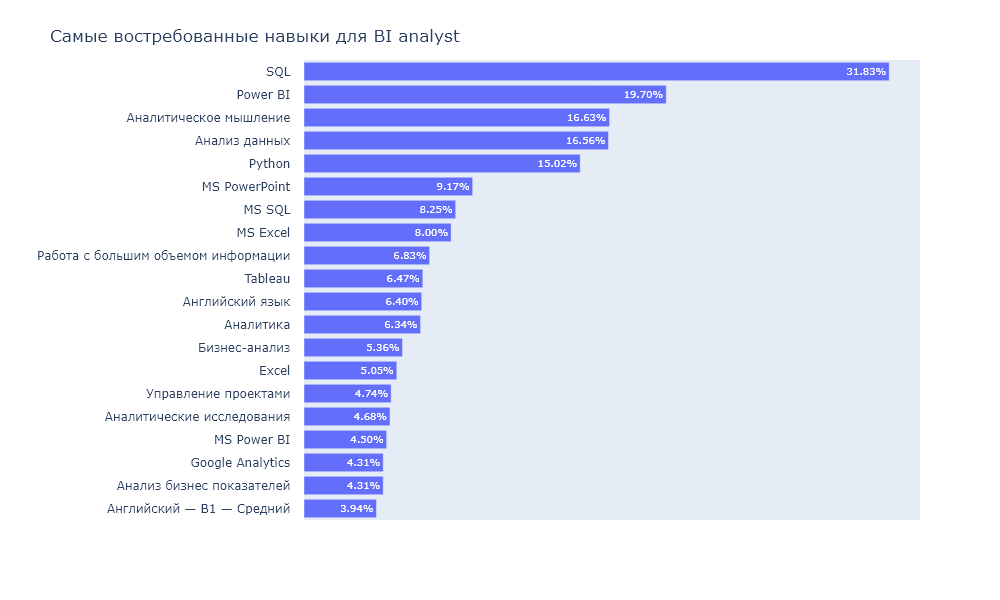

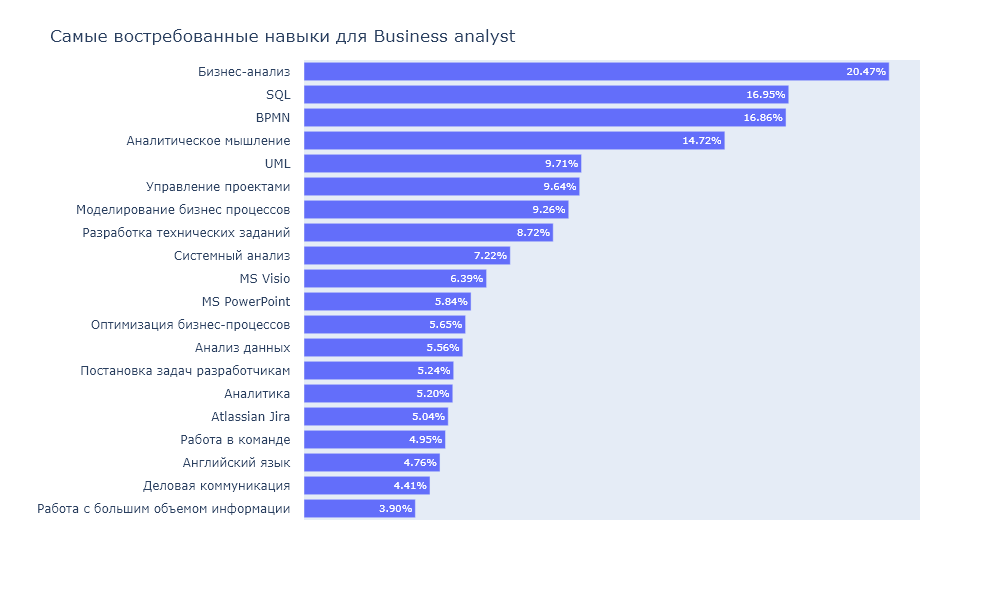

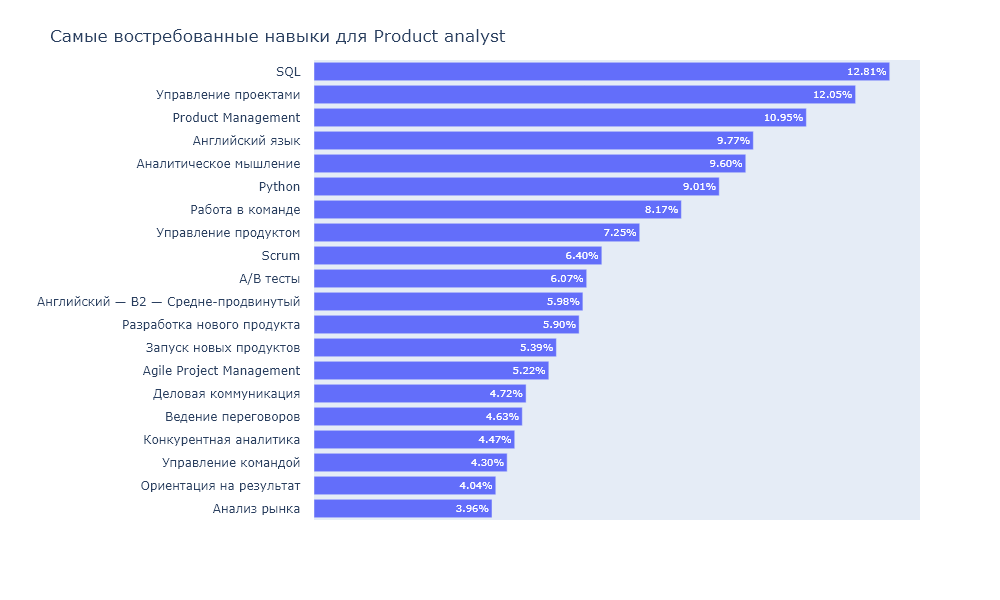

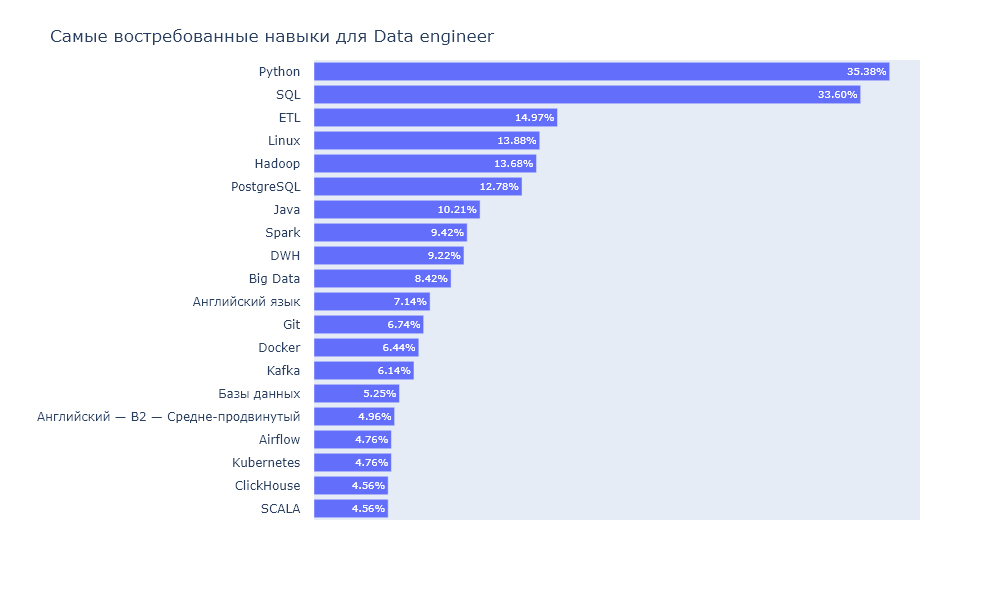

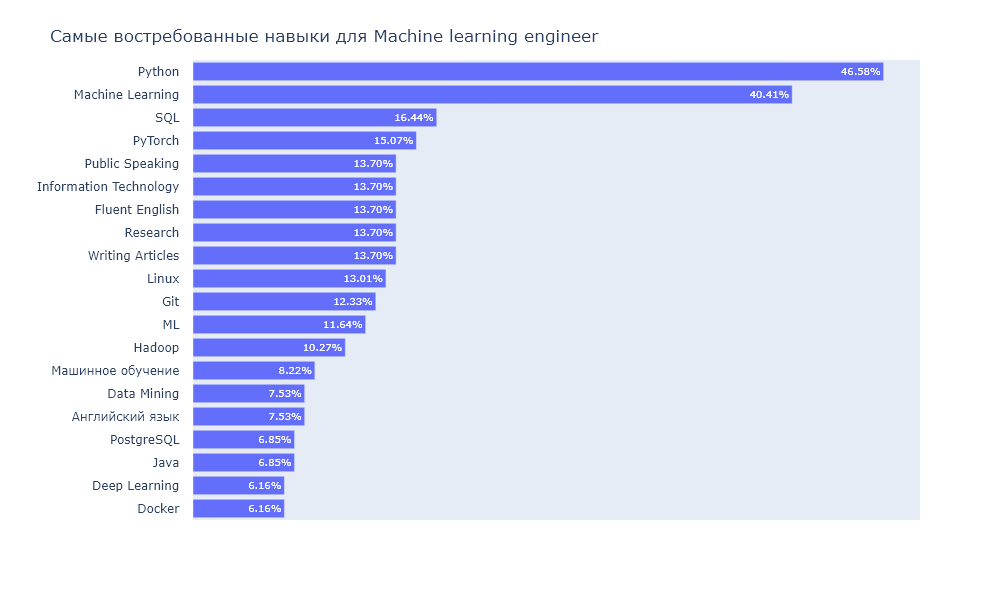

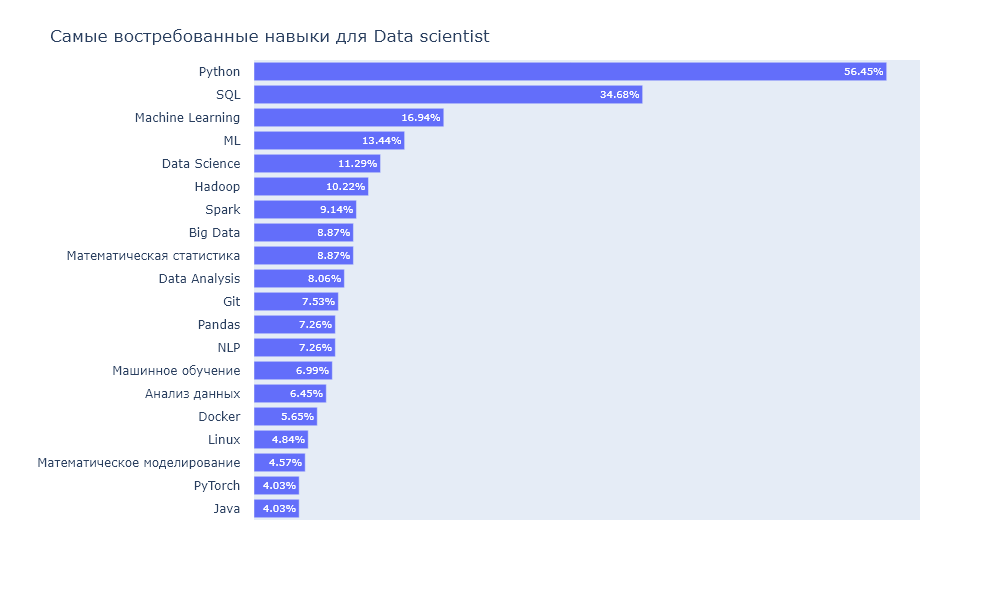

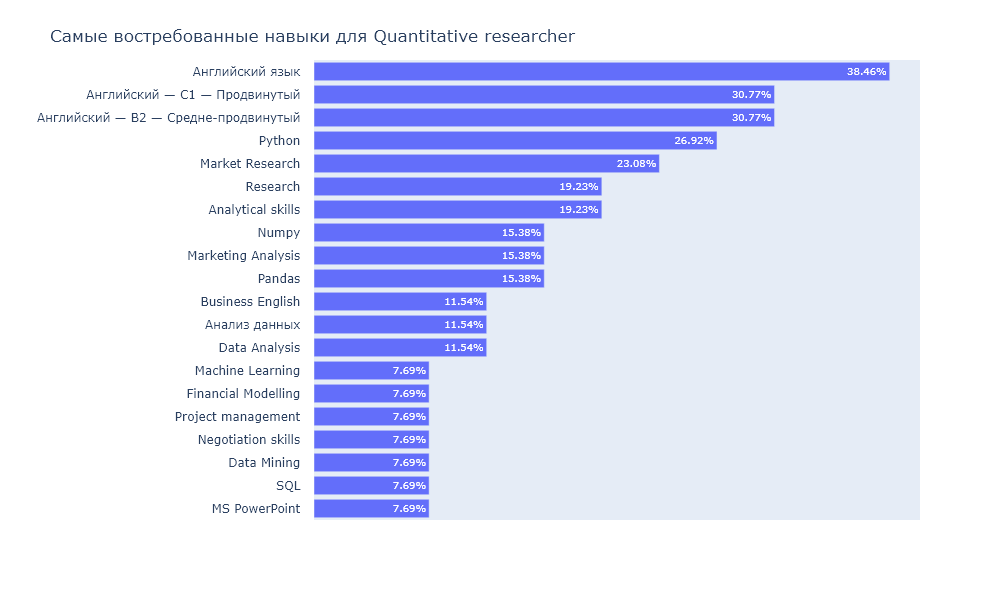

In [34]:
for va in vac:
    df_temp = df[df.role == va]
    skills = (pd.Series([x for b in df_temp['tags'] \
                         for x in b]).value_counts()/len(df_temp))[:20]
    fig = px.bar(x = skills.sort_values().values, y = [label+' '* 3 for label in skills.sort_values().index], 
                 text_auto='.2%', labels = {'x': '', 'y': ''}, width=1000, height=600)
    fig.update_layout(
        title={
            'text': f'Самые востребованные навыки для {va}', 
            'yanchor': 'top'},
    )
    fig.update_xaxes(visible=False)
    fig.show("png")

## 5 Результаты

### 5.1 Результаты по вакансиям

На март 2023 года самыми востребованными являются системные и бизнес-аналитики.  
По опыту ситуация такая:  
    Опыт не требуется в 4% вакансий  
    Опыт 1 - 3 года в 45% вакансий  
    Опыт 3 - 6 лет в 47% вакансий  
    Опыт более 6 лет в 4% вакансий  

### 5.2 Результаты по зарплате

По зарплате(медиана):  
    Опыт не требуется: самая большая у Data analyst(80.45k)  
    Опыт 1 - 3 года: самая большая у Data scientist(198.27k)  
    Опыт 3 - 6 лет: самая большая у Data engineer(316.09k)  
    Опыт более 6 лет: самая большая у Data scientist(488.8k)  

**В действительности, данные могут отличаться из-за того, что только 
22 % вакансий содержат заработные платы
 и в категориях "Опыт не требуется" и "Опыт более 6 лет" содержится малое количество вакансий**

### 5.3 Результаты по навыкам

Для **всех направлений** лидирующим навыком является SQL(топ-3). Остальные навыки меняются, все зависит от направления.  
Для **Data analyst** чаще всего встречаются: SQL, Python, Анализ данных, Аналитическое мышление, Data Analysis  
Для **System analyst** чаще всего встречаются: SQL, UML, Системный анализ, BPMN,Разработка технических заданий  
Для **BI analyst** чаще всего встречаются: SQL, Power BI, Аналитическое мышление, Анализ данных, Python  
Для **Business analyst** чаще всего встречаются: Бизнес-анализ, SQL, BPMN, Аналитическое мышление, UML  
Для **Product analyst** чаще всего встречаются: SQL, Управление проектами, Product Management, Английский язык, Аналитическое мышление  
Для **Data engineer** чаще всего встречаются: Python, SQL, ETL, Linux, Hadoop  
Для **Machine learning engineer** чаще всего встречаются: Python, Machine Learning, SQL, PyTorch, Information Technology  
Для **Data scientist** чаще всего встречаются: Python, SQL, Machine Learning, Data Science  
Для **Quantitative researcher** чаще всего встречаются: Английский язык, Python, Market Research  